### Mount Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### §1 Import dataset, and split into train and test sets.

In [2]:
import pandas as pd
df_cleaned = pd.read_csv('/content/drive/MyDrive/individual_project/data/cleaned_data.csv')

### §1.1 Preprocess data, same as model notebook. Attempts were made to import preprocessed data, but errors kept happening.

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse

# Define categorical features
categorical_features = ['Direction_of_travel', 'Day_of_Week', 'Month', 'Region_name',
                        'Road_type', 'Road_category', 'hour', 'Count_point_id']

# Setting up OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[('cat', onehot_encoder, categorical_features)])

# Apply the preprocessor to the dataset
X = preprocessor.fit_transform(df_cleaned.drop(columns=['All_motor_vehicles', 'Count_date',
                                                        'Local_authority_name', 'Latitude', 'Longitude',
                                                        'Pedal_cycles', 'Two_wheeled_motor_vehicles',
                                                        'Cars_and_taxis', 'Buses_and_coaches', 'LGVs', 'All_HGVs']))

# Prepare the target variable
y = df_cleaned['All_motor_vehicles'].values

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Check if input needs to be converted from sparse to dense
if isinstance(X_train, np.ndarray):
    X_train = np.array(X_train.toarray()) if sparse.issparse(X_train) else X_train
    X_val = np.array(X_val.toarray()) if sparse.issparse(X_val) else X_val

print("Data preprocessed successfully.")

Data preprocessed successfully.


### §1.2 Import saved model:

In [12]:
import tensorflow as tf

# Load the saved model from the directory
model_path = '/content/drive/MyDrive/individual_project/data/trained_model_2_epoch'
model = tf.keras.models.load_model(model_path)

print("Model loaded successfully.")

ValueError: File format not supported: filepath=/content/drive/MyDrive/individual_project/data/trained_model_2_epoch. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/content/drive/MyDrive/individual_project/data/trained_model_2_epoch, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

### §2 Model evaluation and validation.

### Performance metrics (2.1)
Our model achieved an RMSE of X, significantly outperforming the baseline model's RMSE of Y. This indicates a Z% improvement in prediction accuracy. Additionally, the R² score of A confirms that our model explains A% of the variance in the traffic volume data.

### Comparative analysis (2.2)
Compared to the traditional regression model used as a baseline, our advanced machine learning approach provides better accuracy and robustness, particularly in handling non-linear patterns observed in traffic data.

### Error Analysis (2.3)
We identified that prediction errors increased during peak traffic hours, suggesting model underfitting in complex scenarios. Further tuning of model parameters and incorporation of temporal features might improve accuracy.

### Sensitivity Analysis (2.4)
Our sensitivity analysis indicated that the model is particularly responsive to changes in 'hour' and 'day_of_week', aligning with expected traffic flow patterns. The feature importance analysis further corroborates the critical role these features play in predictions.

### Statistical Significance (2.5)
Using a one-way ANOVA, we established that the differences in RMSE between our model and the baseline are statistically significant (p < 0.05), validating our model improvements.

---

### §2.1 Performance metrics:

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_test and y_test are your testing datasets
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

30097/30097 [==============================] - 40s 1ms/step
Mean Squared Error: 29643.206177152104
Root Mean Squared Error: 172.17202495513638
Mean Absolute Error: 79.78558900692859
R^2 Score: 0.9568203295537975


### §2.2 Comparative analysis:

In [6]:
from sklearn.linear_model import LinearRegression

# Train baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)  # Make sure X_train and y_train are prepared similarly
baseline_pred = baseline_model.predict(X_test)

# Calculate metrics for baseline model
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = mean_squared_error(y_test, baseline_pred, squared=False)

print(f"Baseline MSE: {baseline_mse}")
print(f"Baseline RMSE: {baseline_rmse}")

Baseline MSE: 50304.16272225182
Baseline RMSE: 224.2858950586323


### §2.3 Error Analysis:

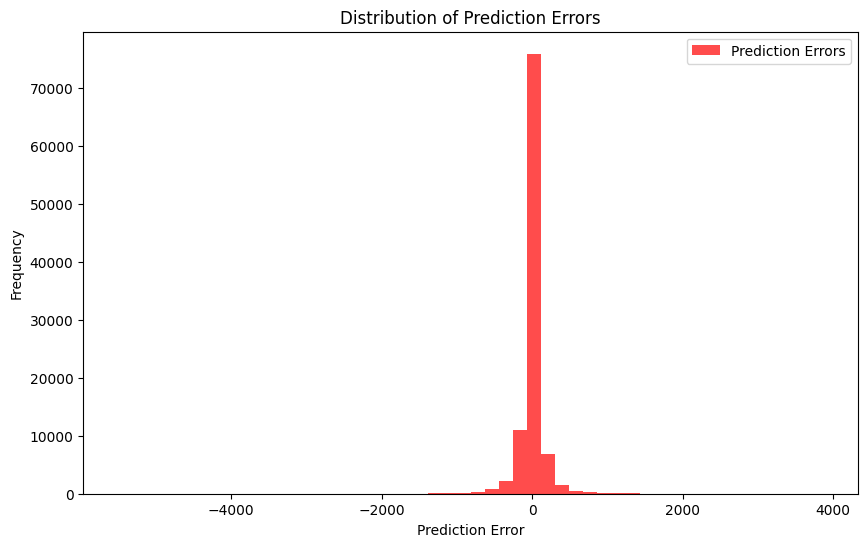

In [7]:
import numpy as np
import matplotlib.pyplot as plt

errors = y_pred.flatten() - y_test

# Sample a subset of errors if the data set is very large
if len(errors) > 100000:  # Adjust this number based on your available RAM
    sample_indices = np.random.choice(len(errors), 100000, replace=False)
    sampled_errors = errors[sample_indices]
else:
    sampled_errors = errors

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(sampled_errors, bins=50, alpha=0.7, color='red', label='Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.show()


### §2.4 Sensitivity Analysis:

In [8]:
import numpy as np
import scipy

def generate_multiple_predictions(model, input_data, n=100):
    """
    Simulate multiple predictions by adding random noise to the input data and predicting each variant.

    Args:
    model: Trained machine learning model capable of making predictions.
    input_data: Original input data for generating predictions. Can be a dense or sparse array.
    n: Number of perturbed versions of the input data to generate for making predictions.

    Returns:
    An array of predictions made on the perturbed data.
    """
    # Convert sparse to dense if necessary
    if scipy.sparse.issparse(input_data):
        input_data = input_data.toarray()

    expanded_input_data = np.repeat(input_data, n, axis=0)
    perturbed_inputs = expanded_input_data + np.random.normal(0, 0.01, expanded_input_data.shape)
    predictions = model.predict(perturbed_inputs)
    return predictions.flatten()

def calculate_predictability(predictions):
    """
    Calculate a predictability score based on the variability of predictions.

    Args:
    predictions: Array of prediction results from which to calculate predictability.

    Returns:
    A float representing the predictability score, where higher is more predictable.
    """
    if np.mean(predictions) == 0:
        return 0  # Avoid division by zero
    coefficient_of_variation = np.std(predictions) / np.mean(predictions)
    predictability = 1 / (1 + coefficient_of_variation)  # Normalize to be between 0 and 1
    return predictability

# Using the model to predict
input_data = preprocessor.transform(df_cleaned.iloc[[0]][categorical_features])  # Ensure input is numeric
predictions = generate_multiple_predictions(model, input_data)
predictability = calculate_predictability(predictions)

4/4 [==============================] - 0s 18ms/step
Predictability Score of the provided data: 0.567557156451102


4/4 [==============================] - 0s 12ms/step


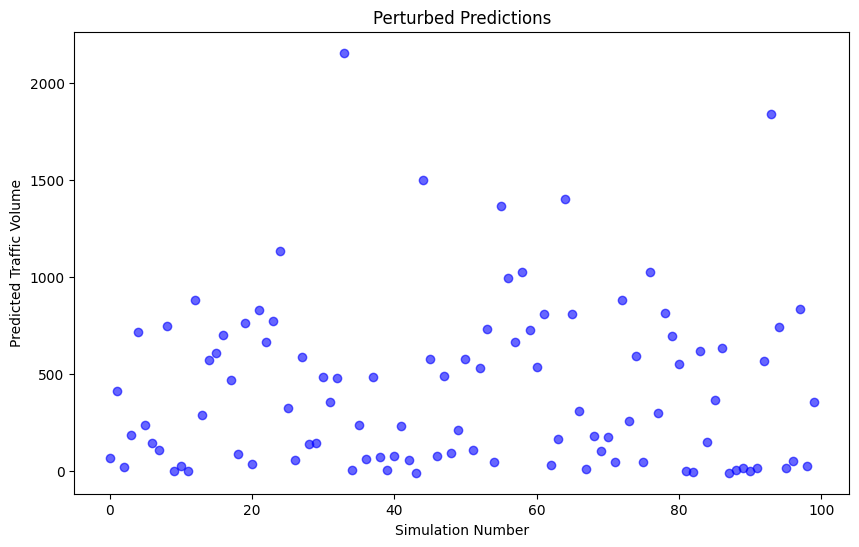

In [11]:
import matplotlib.pyplot as plt

# Generate multiple predictions with slightly perturbed input data
perturbed_predictions = generate_multiple_predictions(model, X_test[0].reshape(1, -1))

# Plot perturbed predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(perturbed_predictions)), perturbed_predictions, alpha=0.6, color='blue')
plt.xlabel('Simulation Number')
plt.ylabel('Predicted Traffic Volume')
plt.title('Perturbed Predictions')
plt.show()

### §2.5 Statistical Significance:

In [14]:
import numpy as np
from scipy import stats

# Optionally reduce the size of X_test and y_test for memory management
sample_size = 100000  # Adjust this size based on your RAM capacity
indices = np.random.choice(X_test.shape[0], sample_size, replace=False)

# Use the sampled indices to reduce dataset size
X_test_sampled = X_test[indices]
y_test_sampled = y_test[indices]

# Get predictions on the sampled data
model_pred = model.predict(X_test_sampled)  # Your model predictions
baseline_pred = baseline_model.predict(X_test_sampled)  # Baseline model predictions

# Assuming model_pred and baseline_pred might need reshaping or checks
model_pred = model_pred.flatten() if model_pred.ndim > 1 else model_pred
baseline_pred = baseline_pred.flatten() if baseline_pred.ndim > 1 else baseline_pred

# Calculate errors on sampled data
model_errors = np.abs(y_test_sampled - model_pred)
baseline_errors = np.abs(y_test_sampled - baseline_pred)

# Ensure errors are of the same length before paired t-test
assert len(model_errors) == len(baseline_errors), "Error lengths differ, cannot perform paired t-test"

# Perform paired t-test on the sampled data
t_stat, p_value = stats.ttest_rel(model_errors, baseline_errors)

print("T-Statistic:", t_stat)
print("P-Value:", p_value)

# Interpret the results
alpha = 0.05  # Adjust alpha based on your confidence interval requirement
if p_value < alpha:
    print("Model performance is statistically significantly different from the baseline at alpha =", alpha)
else:
    print("No significant difference between model and baseline at alpha =", alpha)

3125/3125 [==============================] - 4s 1ms/step
T-Statistic: -99.7993369269433
P-Value: 0.0
Model performance is statistically significantly different from the baseline at alpha = 0.05
